In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import scgen
from feature_attribution_sc.explainers.mask import mask, generate_rankings

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

Global seed set to 0
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2023-03-02 19:43:56.226292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-02 19:43:56.226460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-02 19:43:56.226465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing librari

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.0 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.3 pynndescent==0.5.7


In [2]:
data_path='/home/yuge/feature-attribution-sc'

In [3]:
adata = sc.read(f'{data_path}/datasets/2301_scgen_norman19.h5ad')

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sparsity before:

In [4]:
sparsity_before = adata.X.nnz / (adata.shape[0] * adata.shape[1])
sparsity_before

0.3384200130038666

Set up the model for training as usual.

In [5]:
scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')
model = scgen.SCGEN(adata)

Pull out the tensor form of the data for passing to the model manually.

In [6]:
batch_size = adata.shape[0]
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)
batch = next(scdl.__iter__())

Mask data according to a feature importance ranking, across multiple thresholds.

In [7]:
# feature_importance = f'{data_path}/outputs/baselines/task1_random.csv'
# feature_importance = f'{data_path}/outputs/differential_expression/norman_DE_control.csv'  # these are way slower for some reason???
feature_importance = f'{data_path}/outputs/expected_gradients/task_1_absolute_expected_grads_v2.csv'

In [8]:
rankings, gene_indices = generate_rankings(pd.read_csv(feature_importance))  # probably should generate gene indices from adata or idk?

Generating rankings for 107 labels and 919 features.


In [9]:
%%time
incremental_sparsity = []
for threshold in range(0, 100, 10):
    t = float(threshold)/100
    print(t)
    masked_inpt = mask(
        batch['X'], batch['batch'], pd.read_csv(feature_importance), rankings, gene_indices, threshold=t)
    print(masked_inpt.sum())
    # add as a layer in the adata
    adata.layers[f'masked_{threshold}'] = masked_inpt.numpy()  # must cast in order to store in .layers
    
    # record the sparsity for plotting. only applicable if we're masking with zeroes
    sparsity_after = np.count_nonzero(adata.layers[f'masked_{threshold}']) / (adata.shape[0] * adata.shape[1])
    incremental_sparsity.append((t, sparsity_after))

0.0
tensor(21248912.)
0.1
tensor(14912763.)
0.2
tensor(9264469.)
0.3
tensor(5749094.)
0.4
tensor(3943908.)
0.5
tensor(2769997.)
0.6
tensor(2075130.3750)
0.7
tensor(1420292.7500)
0.8
tensor(1075703.8750)
0.9
tensor(758586.3125)
CPU times: user 1min 10s, sys: 3.52 s, total: 1min 13s
Wall time: 1min 7s


Text(0.5, 0, 'frac important features masked')

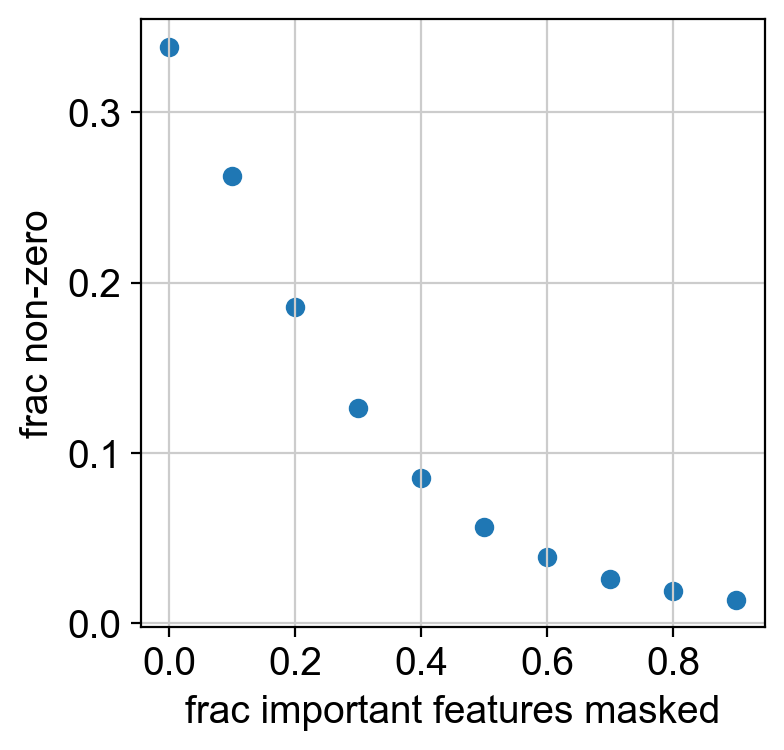

In [10]:
import matplotlib.pyplot as plt
x, y = zip(*incremental_sparsity)
plt.scatter(x, y)
plt.ylabel('frac non-zero')
plt.xlabel('frac important features masked')

### Pass to an existing model

In [11]:
file = 'scgen_norman19_model1_shuffled'
model = scgen.SCGEN.load(f'{data_path}/models/scgen_norman19_model1_shuffled_v2', adata=adata)
model

INFO     File                                                                                
         /home/yuge/feature-attribution-sc/models/scgen_norman19_model1_shuffled_v2/model.pt 
         already downloaded                                                                  


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


SCGEN Model with the following params: 
n_hidden: 400, n_latent: 30, n_layers: 2, dropout_rate: 0.2
Training status: Trained

In [13]:
import torch

In [14]:
for threshold in range(0, 100, 10):
    new_batch = batch.copy()
    new_batch['X'] = torch.tensor(adata.layers[f'masked_{threshold}'])
#     print(sum(new_batch['X'][0]))
    adata.layers[f'masked_{threshold}_pred'] = \
        model.module.forward(new_batch, compute_loss=False)[1]['px'].detach().numpy()

#### Evaluate

In [15]:
example_pert = 'KLF1'  # condition with the most occurrences

TODO: run the full 30min diffexp when you have time

In [16]:
ctrl_adata = adata[adata.obs.perturbation_name.isin(['control', example_pert])]
# ctrl_adata = ad.AnnData(ctrl_adata.X, obs=ctrl_adata.obs, var=ctrl_adata.var)

sc.tl.rank_genes_groups(ctrl_adata, groupby='perturbation_name', reference='control', method='wilcoxon')

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
diff_genes = ctrl_adata.uns['rank_genes_groups']['names'][example_pert]
print(diff_genes[:10])

['TMSB10' 'HBZ' 'PNMT' 'KLF1' 'KLF1' 'HBG2' 'HBA1' 'HBG1' 'EMP3' 'ANXA2']


In [18]:
pred = adata[adata.obs.perturbation_name == example_pert]
pred.obs['perturbation_name'] = 'pred'

/tmp/ipykernel_249579/2034322870.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['perturbation_name'] = 'pred'
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [19]:
pred.var_names_make_unique()
ctrl_adata.var_names_make_unique()

586248.4


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


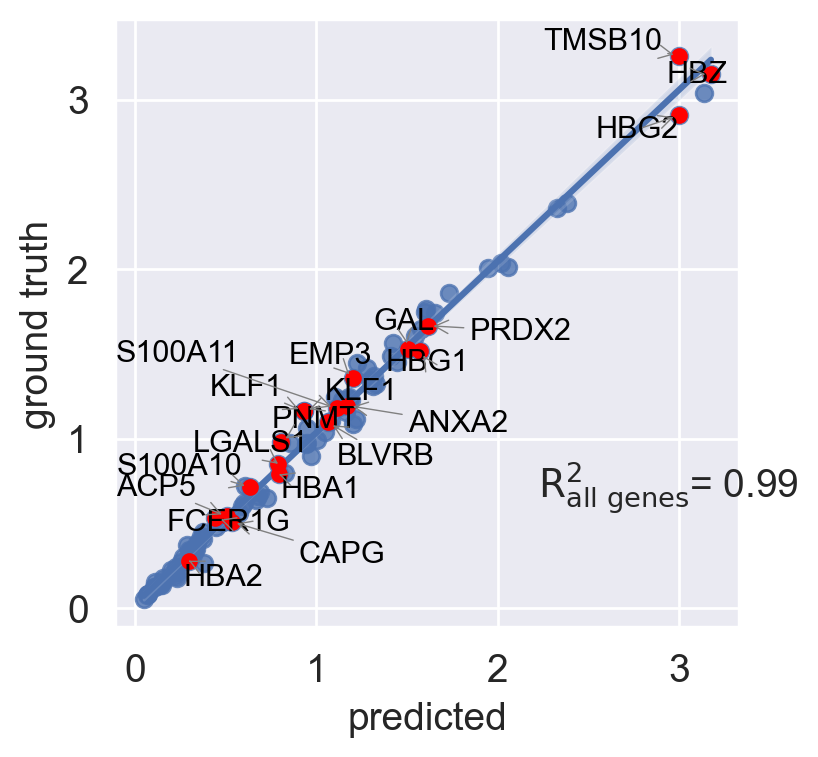

377916.16


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


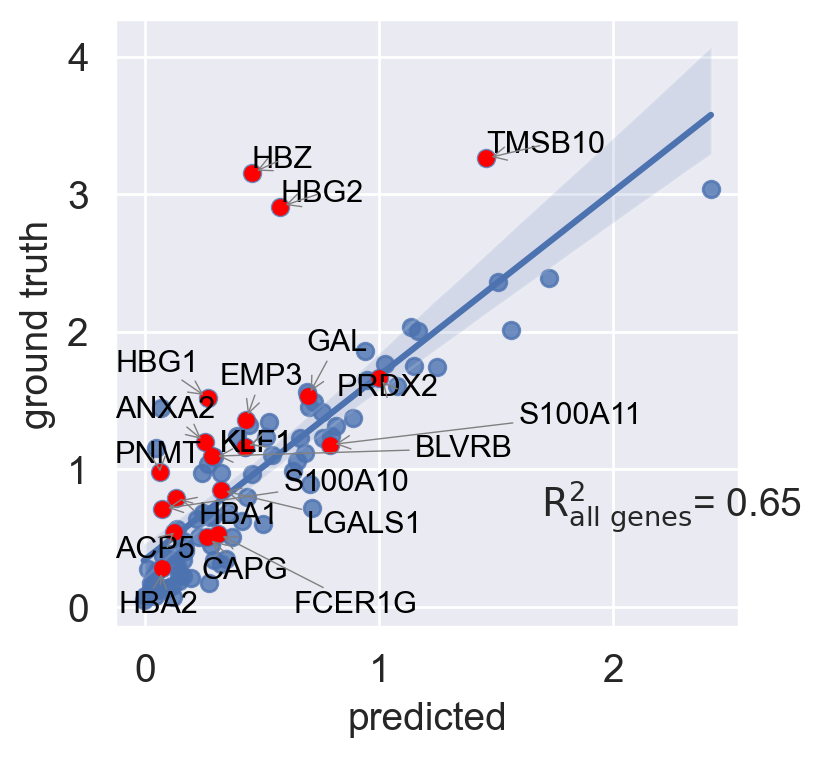

242933.47


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


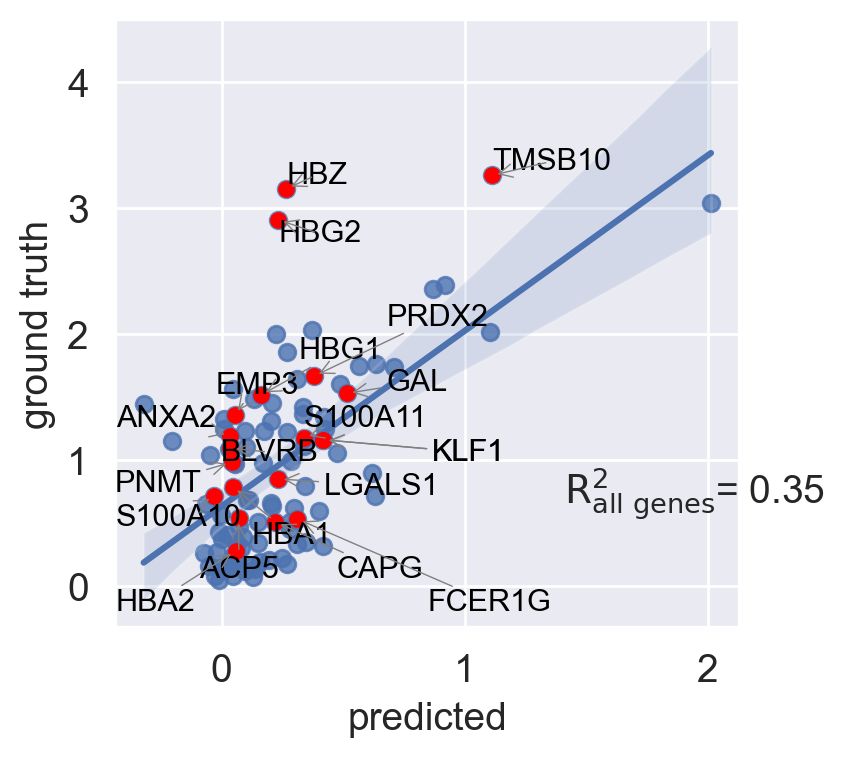

187727.02


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


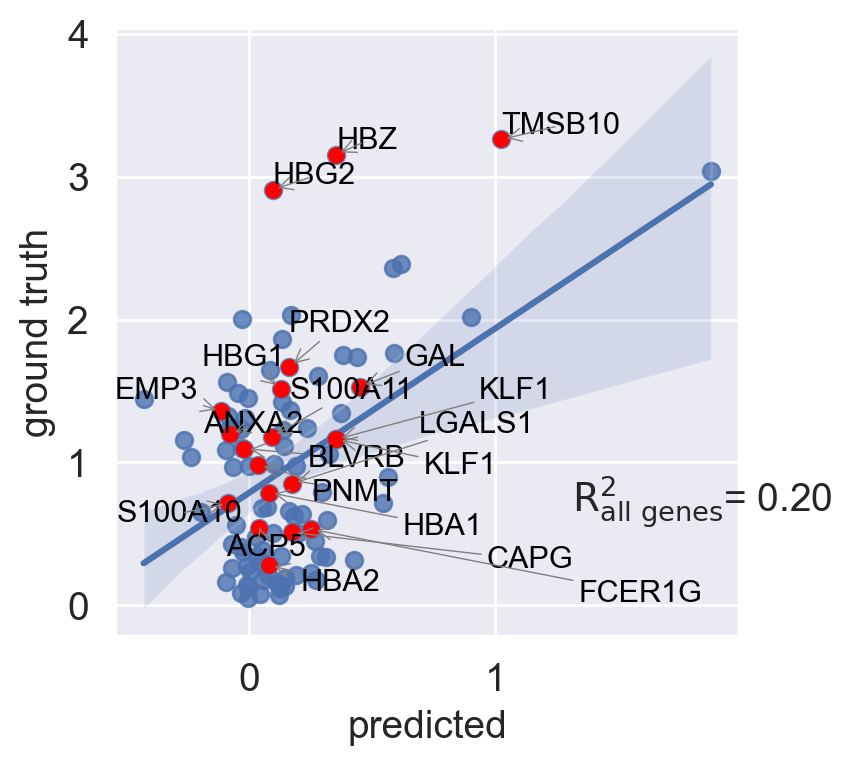

168586.8


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


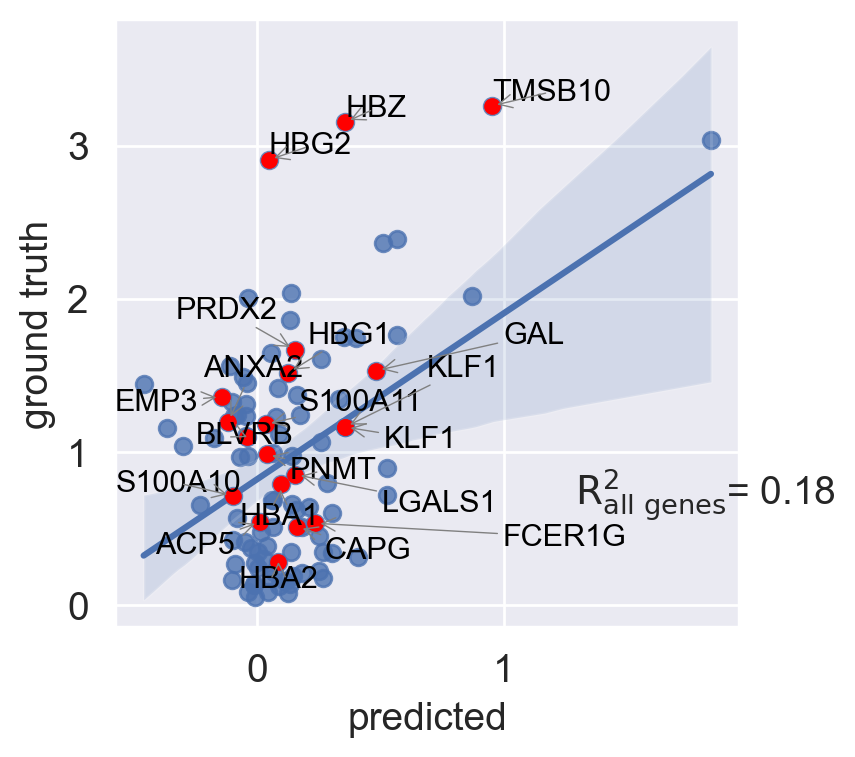

158018.75


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


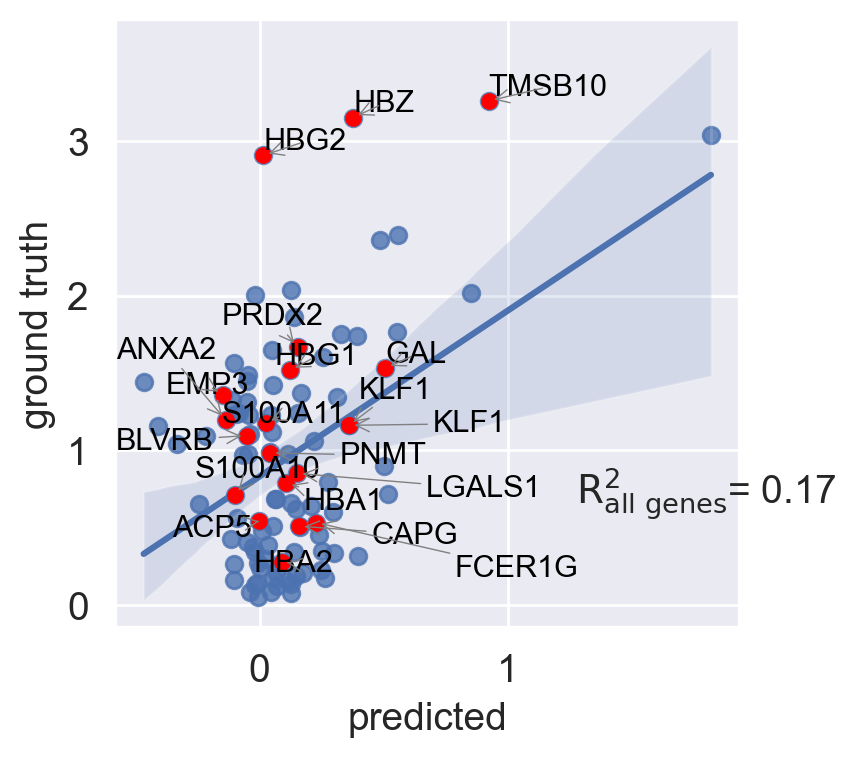

156087.62


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


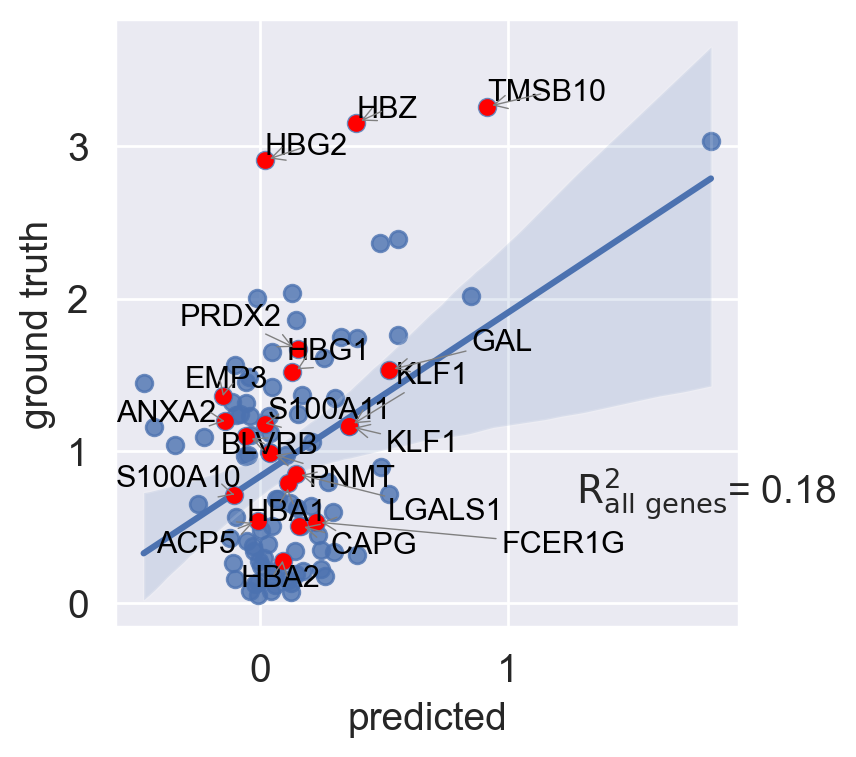

153394.44


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


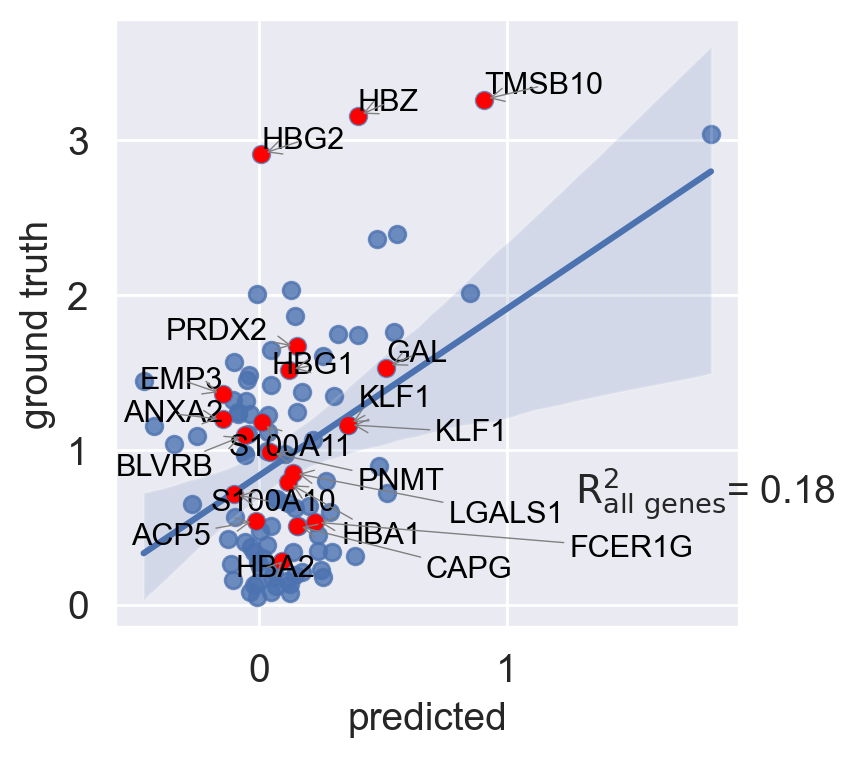

151130.16


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


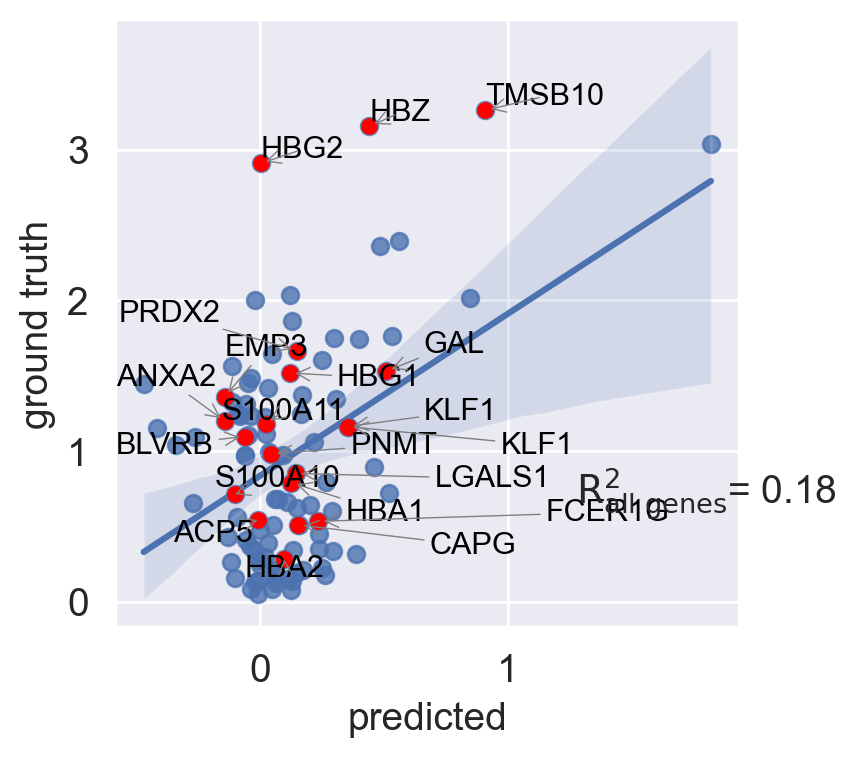

150278.7


/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


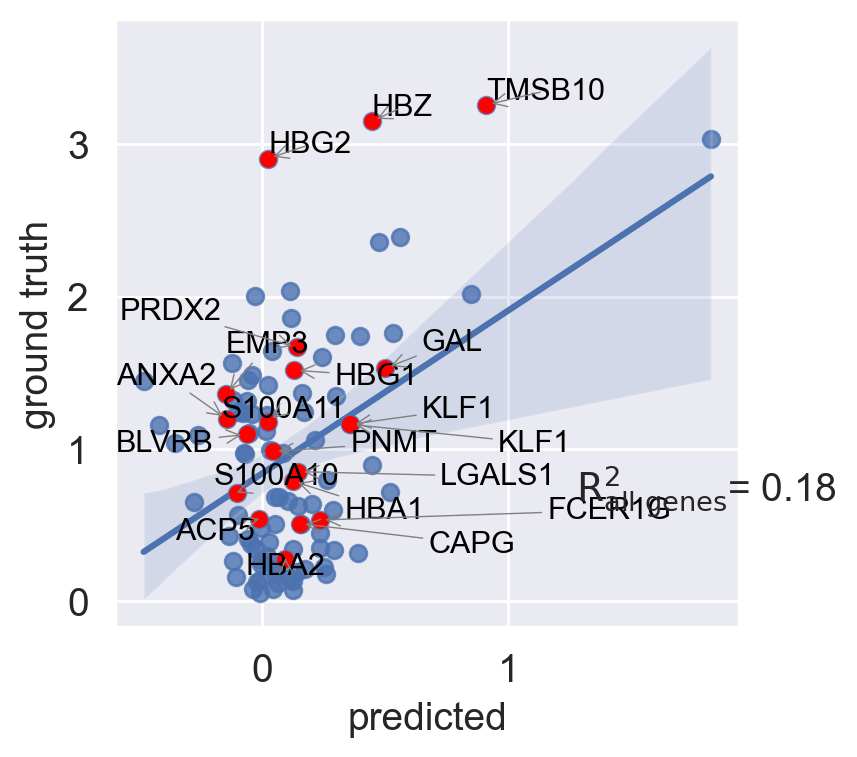

In [25]:
r2s = []
for threshold in range(0, 100, 10):
    pred.X = pred.layers[f'masked_{threshold}_pred']
    print(pred.X.sum())
    eval_adata = pred.concatenate(ctrl_adata)[:, diff_genes[:100]]
    
    r2_value = model.reg_mean_plot(
        eval_adata,
        axis_keys={'x': 'pred', 'y': example_pert},
        gene_list=diff_genes[:20],
        labels={'x': 'predicted', 'y': 'ground truth'},
        show=True,
        legend=False
    )
    r2s.append((threshold, r2_value))

Text(0.5, 0, 'percent important features masked')

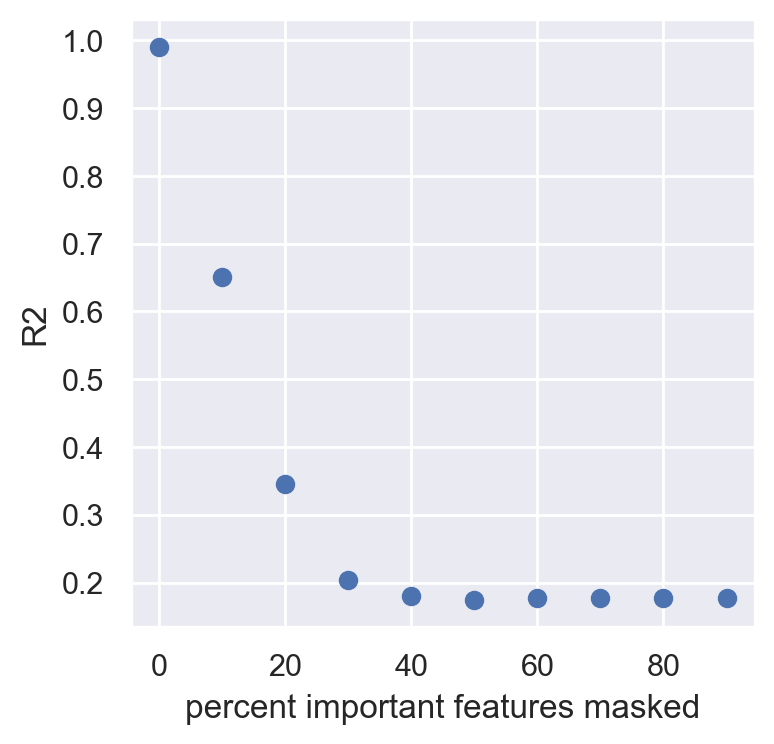

In [26]:
import matplotlib.pyplot as plt
x, y = zip(*r2s)
plt.scatter(x, y)
plt.ylabel('R2')
plt.xlabel('percent important features masked')

### Train a new model

In [12]:
adata.X = masked_inpt.numpy()

In [13]:
scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')
model = scgen.SCGEN(adata)

In [ ]:
# TRAIN
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=False,
#         early_stopping_patience=25
)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 2/100:   1%|█▊                                                                                                                                                                                  | 1/100 [03:05<5:06:25, 185.71s/it, loss=232, v_num=1]

In [20]:
CHECKPOINT_PATH=f'{data_path}/trained_models/scgen/'
CHECKPOINT_PATH = CHECKPOINT_PATH + feature_importance.split('/')[-1].split('.')[
    0] + '_' + str(threshold) + '_checkpoints.pt'  # set checkpoint path
print(f'CHECKPOINT_PATH: {CHECKPOINT_PATH}')

model.save(CHECKPOINT_PATH, overwrite=True)  # save model to checkpoint

CHECKPOINT_PATH: /home/yuge/feature-attribution-sc/trained_models/scgen/task1_random_0.5_checkpoints.pt
